# SNF Network-based credit risk models in P2P lending markets
Goal: See whether the predictive accuracy of the ML or DL models improve when we include the centrality parameters. So its about checking the AUC values on models trained with and without the centrality measures.

jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

# Libraries

## install missing packages

In [1]:
def install_missing_packages(package_names):
    """
    Install Missing Packages

    This function checks if a list of packages is already installed and installs any missing packages using pip.

    Parameters:
    - package_names (list): A list of package names to be installed.

    Returns:
    - None

    Note: This function requires the `subprocess` and `importlib` modules to be imported.

    Example Usage:
    install_missing_packages(['h2o', 'numpy', 'pandas'])
    """
    import importlib
    import subprocess


    for package_name in package_names:
        try:
            importlib.import_module(package_name)
            print(f"{package_name} package is already installed")
        except ImportError:
            print(f"{package_name} package not found, installing with pip...")
            subprocess.call(['pip', 'install', package_name])


In [15]:
# TODO YOU NEED TO HAVE R installed
package_list = ['shap','plotly','matplotlib','tabulate','h2o','reportlab']
install_missing_packages(package_list)

shap package is already installed
plotly package is already installed
matplotlib package is already installed
tabulate package is already installed
h2o package is already installed
reportlab package not found, installing with pip...
  Using cached reportlab-4.0.4-py3-none-any.whl (1.9 MB)


## general libraries

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import webbrowser
import pandas as pd
import importlib
import subprocess
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import importlib
import subprocess

import os
import hashlib

import json


In [10]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from tabulate import tabulate

## h2o models

In [13]:
"""
H2O Models

This module provides a set of utility functions for working with H2O models. H2O is an open-source machine learning platform that provides a distributed environment for building and deploying machine learning models.

Functions:
- load_model(model_path): Load an H2O model from the specified path and return the model object.
- save_model(model, model_path): Save the given H2O model to the specified path.
- predict(model, data): Generate predictions using the specified H2O model on the given data.
- evaluate(model, data): Evaluate the performance of the specified H2O model on the given data and return relevant metrics.
- get_model_details(model): Get detailed information about the specified H2O model, including its parameters and performance statistics.
- get_feature_importance(model): Get the feature importance scores for the specified H2O model, indicating the importance of each feature in the model's predictions.

Note: These functions require the H2O Python library to be installed and imported.

For more information on H2O, visit the official documentation at https://docs.h2o.ai/.
"""

import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGeneralizedLinearEstimator, H2ORandomForestEstimator, H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch
import h2o.estimators.glm
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [16]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

In [66]:
import shap

# Functions

## Read and write data

In [17]:
def read_df_from_disk(directory, filename, parameters):
    """
    Given a directory name, a file name, and a list of parameters,
    reads the data from the file with the specified name and returns it as a Pandas DataFrame.

    Args:
        directory (str): The name of the directory to read the file from.
        filename (str): The name of the file to read.
        parameters (list): A list of parameters that were included in the filename.

    Returns:
        pandas.DataFrame: The data from the file as a Pandas DataFrame.

    Example:
        >>> directory = 'data'
        >>> filename = 'param1_param2_example.csv'
        >>> parameters = ['param1', 'param2']
        >>> df = read_df_from_disk(directory, filename, parameters)
    """
    # navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())
    
    # navigate into directory
    dir_path = os.path.join(parent_dir, directory)
    
    # merge directory path with file name
    file_path = os.path.join(dir_path, parameters + "_" + filename)
    
    # read dataframe from file
    dataframe = pd.read_csv(file_path)
    
    return dataframe


In [18]:
def read_list_from_disk(directory, filename, parameters):
    """
    Given a directory name, a file name, and a list of parameters,
    reads the data from the file with the specified name and returns it as a list.

    Args:
        directory (str): The name of the directory to read the file from.
        filename (str): The name of the file to read.
        parameters (list): A list of parameters that were included in the filename.

    Returns:
        list: The data from the file as a list.

    Example:
        >>> directory = 'data'
        >>> filename = 'param1_param2_example.txt'
        >>> parameters = ['param1', 'param2']
        >>> lst = read_list_from_disk(directory, filename, parameters)
    """
    # Navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())

    # Navigate into directory
    dir_path = os.path.join(parent_dir, directory)

    # Merge directory path with file name, including parameters in the file name
    file_path = os.path.join(dir_path, "_".join(parameters) + "_" + filename)

    # Read list from file
    with open(file_path, 'r') as f:
        lst = [line.strip() for line in f]
    
    return lst


In [19]:
def calculate_hash(string):
    """Calculate SHA-256 hash of a given string"""
    hash_object = hashlib.sha256(string.encode())
    hex_dig = hash_object.hexdigest()
    return hex_dig
hash_result = calculate_hash("hello world")
print(hash_result)
# Output:  b94d27b9934d3e08a52e52d7da7dabfac484efe37a5380ee9088f7ace2efcde9


b94d27b9934d3e08a52e52d7da7dabfac484efe37a5380ee9088f7ace2efcde9


In [20]:
# function to search for models specific files
import os

def search_file_in_directory(directory, filename):
    """
    Search for a specific file in a directory.
    
    Parameters:
    directory (str): The directory to search in.
    filename (str): The name of the file to search for.

    Returns:
    bool: Whether the file was found.
    """
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.name == filename:
                print(f'File found: {entry.name}')
                return True
    print(f'File not found: {filename}')
    return False


## H20 
related functions

In [21]:
def pandas_to_h2o(data):
    # Convert Pandas DataFrame to H2OFrame
    h2o_df = h2o.H2OFrame(data)
    return h2o_df

def h2o_to_pandas(h2o_df):
    # Convert H2OFrame to Pandas DataFrame
    pandas_df = h2o_df.as_data_frame()

    return pandas_df

In [22]:
def convert_binary_to_categorical(data, binary_columns):
    """
    Convert binary columns in a DataFrame to categorical data type.

    :param data: A pandas DataFrame containing the data.
    :param binary_columns: A list of column names that are binary.
    :return: A new pandas DataFrame with binary columns converted to categorical data type.
    """
    data_categorical = data.copy()

    for column in binary_columns:
        data_categorical[column] = data_categorical[column].astype('category')

    return data_categorical

In [23]:
def convert_to_h2o_frame(pandas_data,binary_columns):
    """
    Convert a pandas DataFrame or Series to an H2O Frame, preserving categorical columns.

    :param pandas_data: pandas DataFrame or Series to be converted
    :return: Converted H2O Frame
    """

    # Convert pandas Series to DataFrame
    if isinstance(pandas_data, pd.Series):
        pandas_data = pandas_data.to_frame()

    # Convert pandas DataFrame to H2O Frame
    h2o_frame = h2o.H2OFrame(pandas_data)

    # Set factor levels for categorical columns in the H2O Frame
    for column in h2o_frame.columns:
        if column in binary_columns:
            h2o_frame[column] = h2o_frame[column].asfactor()

    return h2o_frame

In [24]:
def exclude_columns(data: pd.DataFrame, exclude_list: list) -> pd.DataFrame:
    """
    Exclude specified columns from a Pandas DataFrame.

    Parameters:
    data (pandas.DataFrame): The input Pandas DataFrame.
    exclude_list (list): The list of column names to exclude.

    Returns:
    pandas.DataFrame: A new DataFrame with the specified columns removed.

    """
    new_data = data.drop(exclude_list, axis=1)

    return new_data

In [25]:
def load_h2o_model_from_disk(directory, filename):
    """
    Given a directory name and a file name, loads an H2O model from disk.

    Args:
        directory (str): The name of the directory where the model is saved.
        filename (str): The name of the file where the model is saved.

    Returns:
        H2OEstimator: The loaded H2O estimator object.

    Example:
        >>> directory = 'models'
        >>> filename = 'rf_model'
        >>> loaded_model = load_h2o_model_from_disk(directory, filename)
        >>> predictions = loaded_model.predict(data)
    """
    # Navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())

    # Navigate into directory
    dir_path = os.path.join(parent_dir, directory)

    # Merge directory path with file name
    file_path = os.path.join(dir_path, filename)
    file_path = os.path.join(file_path, filename)
    

    # Load model from file
    loaded_model = h2o.load_model(file_path)
    
    return loaded_model


## Load models

In [26]:
def load_a_group_of_model(directory, hash_CODE):
    a_group_of_model = []
    for hash_code in hash_CODE:
        new_model = load_h2o_model_from_disk(directory, hash_code)
        a_group_of_model.append(new_model)
    return a_group_of_model

## SHAP

In [75]:
model=load_h2o_model_from_disk(directory, filename='e84c48a5b654415c6a342ba0f4276538381729a46201ad8e82f941c93b0d9333')
model

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: e84c48a5b654415c6a342ba0f4276538381729a46201ad8e82f941c93b0d9333


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    200                200                         4.61644e+06            20           20           20            1168          2242          1832.52

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.14723987689318557
RMSE: 0.3837184865147698
LogLoss: 0.45612100798079247
Mean Per-Class Error: 0.2123440430869833
AUC: 0.8731090788232743
AUCPR: 0.8758186217547045
Gini: 0.7462181576465485

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4509864110183092
       0     1     Error    Rate
-----  ----  ----  -------  ----------------
0      5416  1773  0.2466   (1773.0/7189.0)
1      1284  5927  0.1781   (1284.0/7211.0)
Total  6700  7700  0.2123   (3057.0/14400.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450986     0.794984  212
max f2                       0.259239     0.867148  295
max f0point5                 0.579358     0.812415  162
max accuracy                 0.497011     0.794028  194
max precision                0.985362     1         0
max recall                   0.0152127    1         396
max specificity              0.985362     1         0
max absolute_mcc             0.55487      0.588622  171
max min_per_class_accuracy   0.490979     0.7926    196
max mean_per_class_accuracy  0.497011     0.794037  194
max tns                      0.985362     7189      0
max fns                      0.985362     7203      0
max fps                      0.0028891    7189      399
max tps                      0.0152127    7211      396
max tnr                      0.985362     1         0
max fnr                      0.985362     0.998891  0
max fpr                      0.0028891    1         399
max tpr                      0.0152127    1         396

Gains/Lift Table: Avg response rate: 50.08 %, avg score: 50.04 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.960796           1.99695   1.99695            1                0.970992   1                           0.970992            0.0199695       0.0199695                  99.6949   99.6949            0.0199695
2        0.02                        0.947766           1.96921   1.98308            0.986111         0.95401    0.993056                    0.962501            0.0196921       0.0396616                  96.9214   98.3081            0.0393834
3        0.03                        0.937676           1.95535   1.97384            0.979167         0.942331   0.988426                    0.955778            0.0195535       0.0592151                  95.5346   97.3836            0.0585196
4        0.04                        0.926523           1.96921   1.97268            0.986111         0.931958   0.987847                    0.949823            0.0196921       0.0789072                  96.9214   97.2681            0.0779335
5        0.05                        0.917255           1.98308   1.97476            0.993056         0.92198

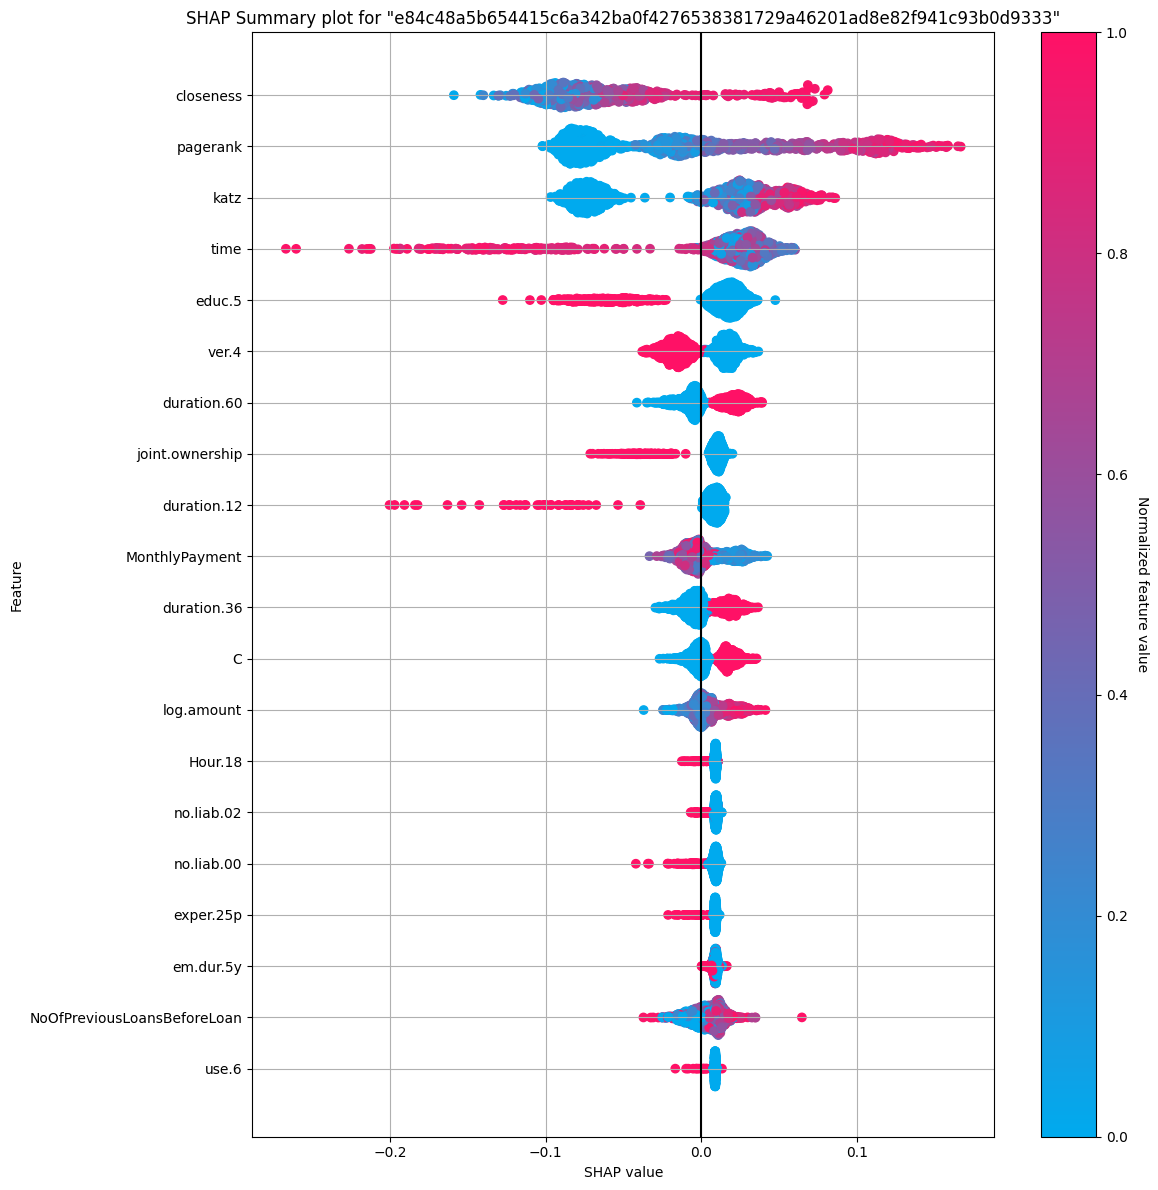

In [76]:
model.shap_summary_plot(X_val.cbind(y_val))

In [68]:
explainer = shap.KernelExplainer(model, X_val.cbind(y_val))  # Use 100 training samples for approximation

AssertionError: Unknown type passed as data object: <class 'h2o.frame.H2OFrame'>

In [72]:
shap_values = model.predict_contributions(X_val)

H2OTypeError: This model doesn't support calculation of feature contributions. When features are independent, you can use the coef() method to get coefficients for non-standardized data or coef_norm() to get coefficients for standardized data. You can plot standardized coefficient magnitudes by calling std_coef_plot() on the model.

# Parameters1

## Hash Code

In [42]:
hash_code=['8e6d6d0d2b4fb095e27a4b8e763989c4785f7fcaf44580714acb060ce0190b54','bebdf9b502a85fb82e34b4d6338434ee5aedcb0c7493d79ba20fffe7a4259d0e']

## Parameters for data pre-process

In [43]:
## data parameters

data_directory = "data" # where the data is stored
preprocessed_filename = "preprocessed" # filename we give for storing the preprocessed data, just before training

In [44]:
preprocessed_filename = "preprocessed_shuffled" #goes to the shffuled data set

In [52]:
directory = 'model'
parameter_string = "pandas_washes"

# Auto ML

## Init the H2O package:

In [46]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 8 mins
H2O_cluster_timezone:,Europe/Zurich
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_yil1_ovwrbt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.706 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


# Read back data and convert to H20
Read back the dataset (after cleaning) and convert to H2O df

## Read back data

In [47]:
preprocessed_filename

'preprocessed_shuffled'

In [53]:
data_categorical = read_df_from_disk(directory = data_directory,
                                     filename = preprocessed_filename, 
                                     parameters = parameter_string)
binary_columns = read_list_from_disk(directory = data_directory,
                                     filename = preprocessed_filename, 
                                     parameters = "binary columns")
target_column = "default"
feature_columns = [col for col in data_categorical.columns if col != target_column]
print(binary_columns)
print(len(binary_columns))

['new', 'Gender', 'Hour.0', 'Hour.1', 'Hour.2', 'Hour.3', 'Hour.4', 'Hour.5', 'Hour.6', 'Hour.7', 'Hour.8', 'Hour.9', 'Hour.10', 'Hour.11', 'Hour.12', 'Hour.13', 'Hour.14', 'Hour.15', 'Hour.16', 'Hour.17', 'Hour.18', 'Hour.19', 'Hour.20', 'Hour.21', 'Hour.22', 'weekday.1', 'weekday.2', 'weekday.3', 'weekday.4', 'weekday.5', 'weekday.6', 'ver.3', 'ver.4', 'duration.06', 'duration.09', 'duration.12', 'duration.18', 'duration.24', 'duration.36', 'duration.48', 'duration.60', 'use.0', 'use.1', 'use.2', 'use.3', 'use.4', 'use.5', 'use.6', 'use.7', 'use.8', 'educ.2', 'educ.3', 'educ.4', 'educ.5', 'marital.1', 'marital.2', 'marital.3', 'marital.4', 'marital.5', 'depen.0', 'depen.1', 'depen.2', 'depen.3', 'depen.4', 'employ.2', 'employ.3', 'employ.4', 'employ.5', 'employ.6', 'em.dur.other', 'em.dur.ret', 'em.dur.trial', 'em.dur.1y', 'em.dur.2y', 'em.dur.3y', 'em.dur.4y', 'em.dur.5y', 'exper.02y', 'exper.05y', 'exper.10y', 'exper.15y', 'exper.25y', 'exper.25p', 'Other', 'Processing', 'Energy', 

## Train test split

In [54]:
X = data_categorical.drop(target_column, axis=1)
y = data_categorical[target_column]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.4,
                                                    random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                y_test,
                                                test_size=0.5,
                                                random_state=42)

## Convert to H20
also some simple tests

In [56]:
X_train = convert_to_h2o_frame(X_train, binary_columns)
X_test = convert_to_h2o_frame(X_test, binary_columns)
X_val = convert_to_h2o_frame(X_val, binary_columns)

y_train = convert_to_h2o_frame(y_train, 'default')
y_test = convert_to_h2o_frame(y_test, 'default')
y_val = convert_to_h2o_frame(y_val, 'default')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Load and Explain by SHAP